# Model - CIC IoT 2023 Dataset for Cybersecurity Research

[University of New Brunswick - Canadian Institute for Cybersecurity](https://www.unb.ca/cic/datasets/index.html)

# Imports

In [1]:
import sys

import pandas as pd

from IPython.display import HTML

sys.path.append('../')
n_jobs = 30

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

In [24]:
import utils
import model_utils
import visualization as viz

from multi_stage_classifier import MultiStageClassifier, ModelStage

constants = utils.get_constants()
seed = constants['seed']

parquet_path = constants['parquet_path']
refined_parquet_path = constants['refined_parquet_path']

attack_category = constants['attack_category']

## Read datasets

In [4]:
%%time

df = pd.read_parquet(parquet_path)
df_refined = pd.read_parquet(refined_parquet_path)

features_list = utils.get_features_list(df)
refined_features_list = utils.get_features_list(df_refined)

CPU times: user 50.7 s, sys: 12.7 s, total: 1min 3s
Wall time: 4.89 s


# Results from the original paper

## 7+1 Classes

              precision    recall  f1-score   support

      Benign      0.816     0.946     0.876    243322
  BruteForce      0.993     0.147     0.256      2983
        DDoS      0.999     1.000     0.999   7526151
         DoS      0.999     0.997     0.998   1792167
       Mirai      0.999     0.999     0.999    583677
       Recon      0.705     0.708     0.706     78630
    Spoofing      0.883     0.624     0.731    107798
         Web      0.972     0.038     0.073      5433

    accuracy                          0.991  10340161
   macro avg      0.921     0.682     0.705  10340161
weighted avg      0.991     0.991     0.991  10340161



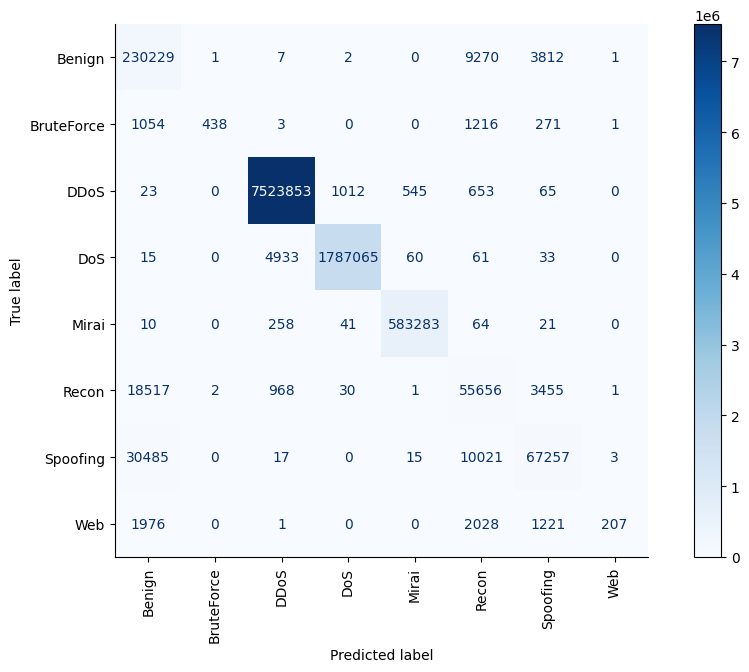

In [5]:
paper_confusion_matrix = pd.DataFrame.from_dict({
    'Benign': [230229,1,7,2,0,9270,3812,1],
    'BruteForce': [1054,438,3,0,0,1216,271,1],
    'DDoS': [23,0,7523853,1012,545,653,65,0],
    'DoS': [15,0,4933,1787065,60,61,33,0],
    'Mirai': [10,0,258,41,583283,64,21,0],
    'Recon': [18517,2,968,30,1,55656,3455,1],
    'Spoofing': [30485,0,17,0,15,10021,67257,3],
    'Web': [1976,0,1,0,0,2028,1221,207],
}, orient='index')

model_utils.show_metrics(
    paper_confusion_matrix.values,
    labels=paper_confusion_matrix.index
)

In [6]:
display(HTML(f"""
<p>
    Interesting to notice that in the paper, the authors mention that they have used a <strong>80/20 split</strong>,
    but based on the length of the dataset released and the absolute values in the Confusion Matrix, 
    we see a slightly different distribution, with the Test data having 
    <strong>{paper_confusion_matrix.sum().sum() / len(df):.2%}</strong> of the data.
</p>
"""))

# Baseline

## 7+1 Attacks

In [5]:
simplified_baseline_df_split = model_utils.get_train_test_split(
    df,
    target='general_label',
    train_frac=0.80
)

Training dataset size: 37.3M (80.0%).
Test dataset size: 9.3M (20.0%).


In [6]:
%%time

simplified_baseline_model = RandomForestClassifier(n_jobs=n_jobs, random_state=seed)

X_train, X_test, y_train, y_test = simplified_baseline_df_split

model_utils.train_model(
    simplified_baseline_model,
    X_train,
    y_train,
    save_name='simplified_baseline_random_forest'
)

Execution time (Model fit): 0:17:34.903705
CPU times: user 6h 54min 10s, sys: 4min 17s, total: 6h 58min 27s
Wall time: 17min 39s


RandomForestClassifier(n_jobs=30, random_state=6958)

# Nodes: 28121672
Execution time (Predict): 0:00:28.104657
              precision    recall  f1-score   support

      Benign     0.9256    0.9811    0.9526    219545
  BruteForce     0.9960    0.5655    0.7214      2656
        DDoS     0.9999    1.0000    0.9999   6797400
         DoS     0.9999    0.9999    0.9999   1617348
       Mirai     1.0000    1.0000    1.0000    526792
       Recon     0.9112    0.8468    0.8778     70864
    Spoofing     0.9208    0.8777    0.8987     97575
         Web     0.9797    0.4521    0.6187      5136

    accuracy                         0.9966   9337316
   macro avg     0.9666    0.8404    0.8836   9337316
weighted avg     0.9966    0.9966    0.9966   9337316

CPU times: user 6min 35s, sys: 37 s, total: 7min 12s
Wall time: 1min 36s


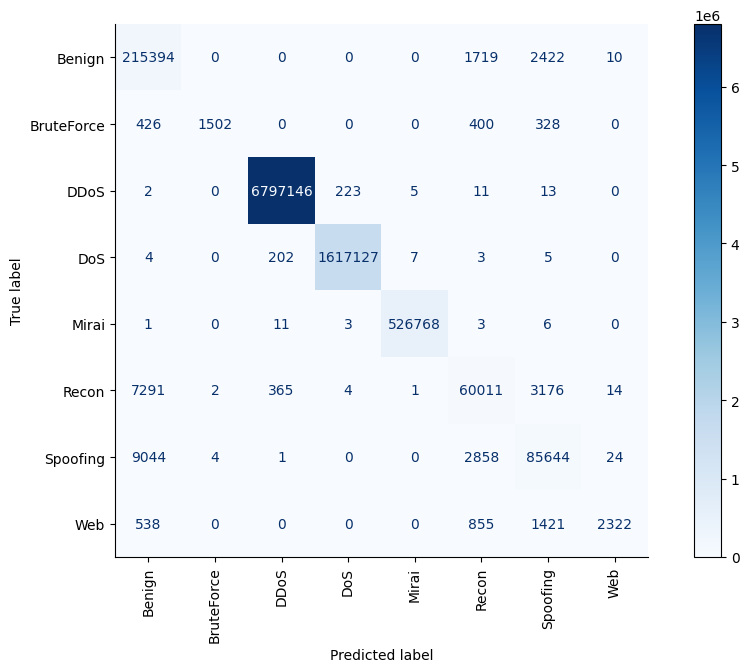

In [11]:
%%time
simplified_baseline_model = model_utils.model_load('simplified_baseline_random_forest')

print(f"# Nodes: {sum(tree.tree_.node_count for tree in simplified_baseline_model.estimators_)}")

X_train, X_test, y_train, y_test = simplified_baseline_df_split
model_utils.evaluate_model(simplified_baseline_model, X_test, y_test)

## 33+1 Attacks

In [8]:
baseline_df_split = model_utils.get_train_test_split(
    df,
    target='label',
    train_frac=0.80
)

Training dataset size: 37.3M (80.0%).
Test dataset size: 9.3M (20.0%).


In [9]:
%%time

baseline_model = RandomForestClassifier(n_jobs=n_jobs, random_state=seed)

X_train, X_test, y_train, y_test = baseline_df_split

model_utils.train_model(
    baseline_model,
    X_train,
    y_train,
    save_name='baseline_random_forest'
)

Execution time (Model fit): 0:18:56.548947
CPU times: user 6h 55min 21s, sys: 4min 42s, total: 7h 3s
Wall time: 19min 49s


RandomForestClassifier(n_jobs=30, random_state=6958)

# Nodes: 44948822
Execution time (Predict): 0:01:37.661273
                         precision    recall  f1-score   support

       Backdoor_Malware     0.9337    0.2534    0.3986       667
          BenignTraffic     0.9073    0.9888    0.9463    219545
       BrowserHijacking     0.9644    0.4089    0.5743      1191
       CommandInjection     0.8542    0.4411    0.5818      1129
 DDoS-ACK_Fragmentation     0.9973    0.9981    0.9977     57361
        DDoS-HTTP_Flood     0.9948    0.9903    0.9925      5771
        DDoS-ICMP_Flood     0.9999    0.9999    0.9999   1439718
DDoS-ICMP_Fragmentation     0.9975    0.9994    0.9985     90845
      DDoS-PSHACK_Flood     0.9999    0.9998    0.9999    819425
       DDoS-RSTFINFlood     0.9999    0.9997    0.9998    808659
         DDoS-SYN_Flood     0.9998    0.9997    0.9998    811376
         DDoS-SlowLoris     0.9681    0.9939    0.9808      4740
DDoS-SynonymousIP_Flood     0.9998    0.9997    0.9997    719660
         DDoS-TCP_Flood     0.

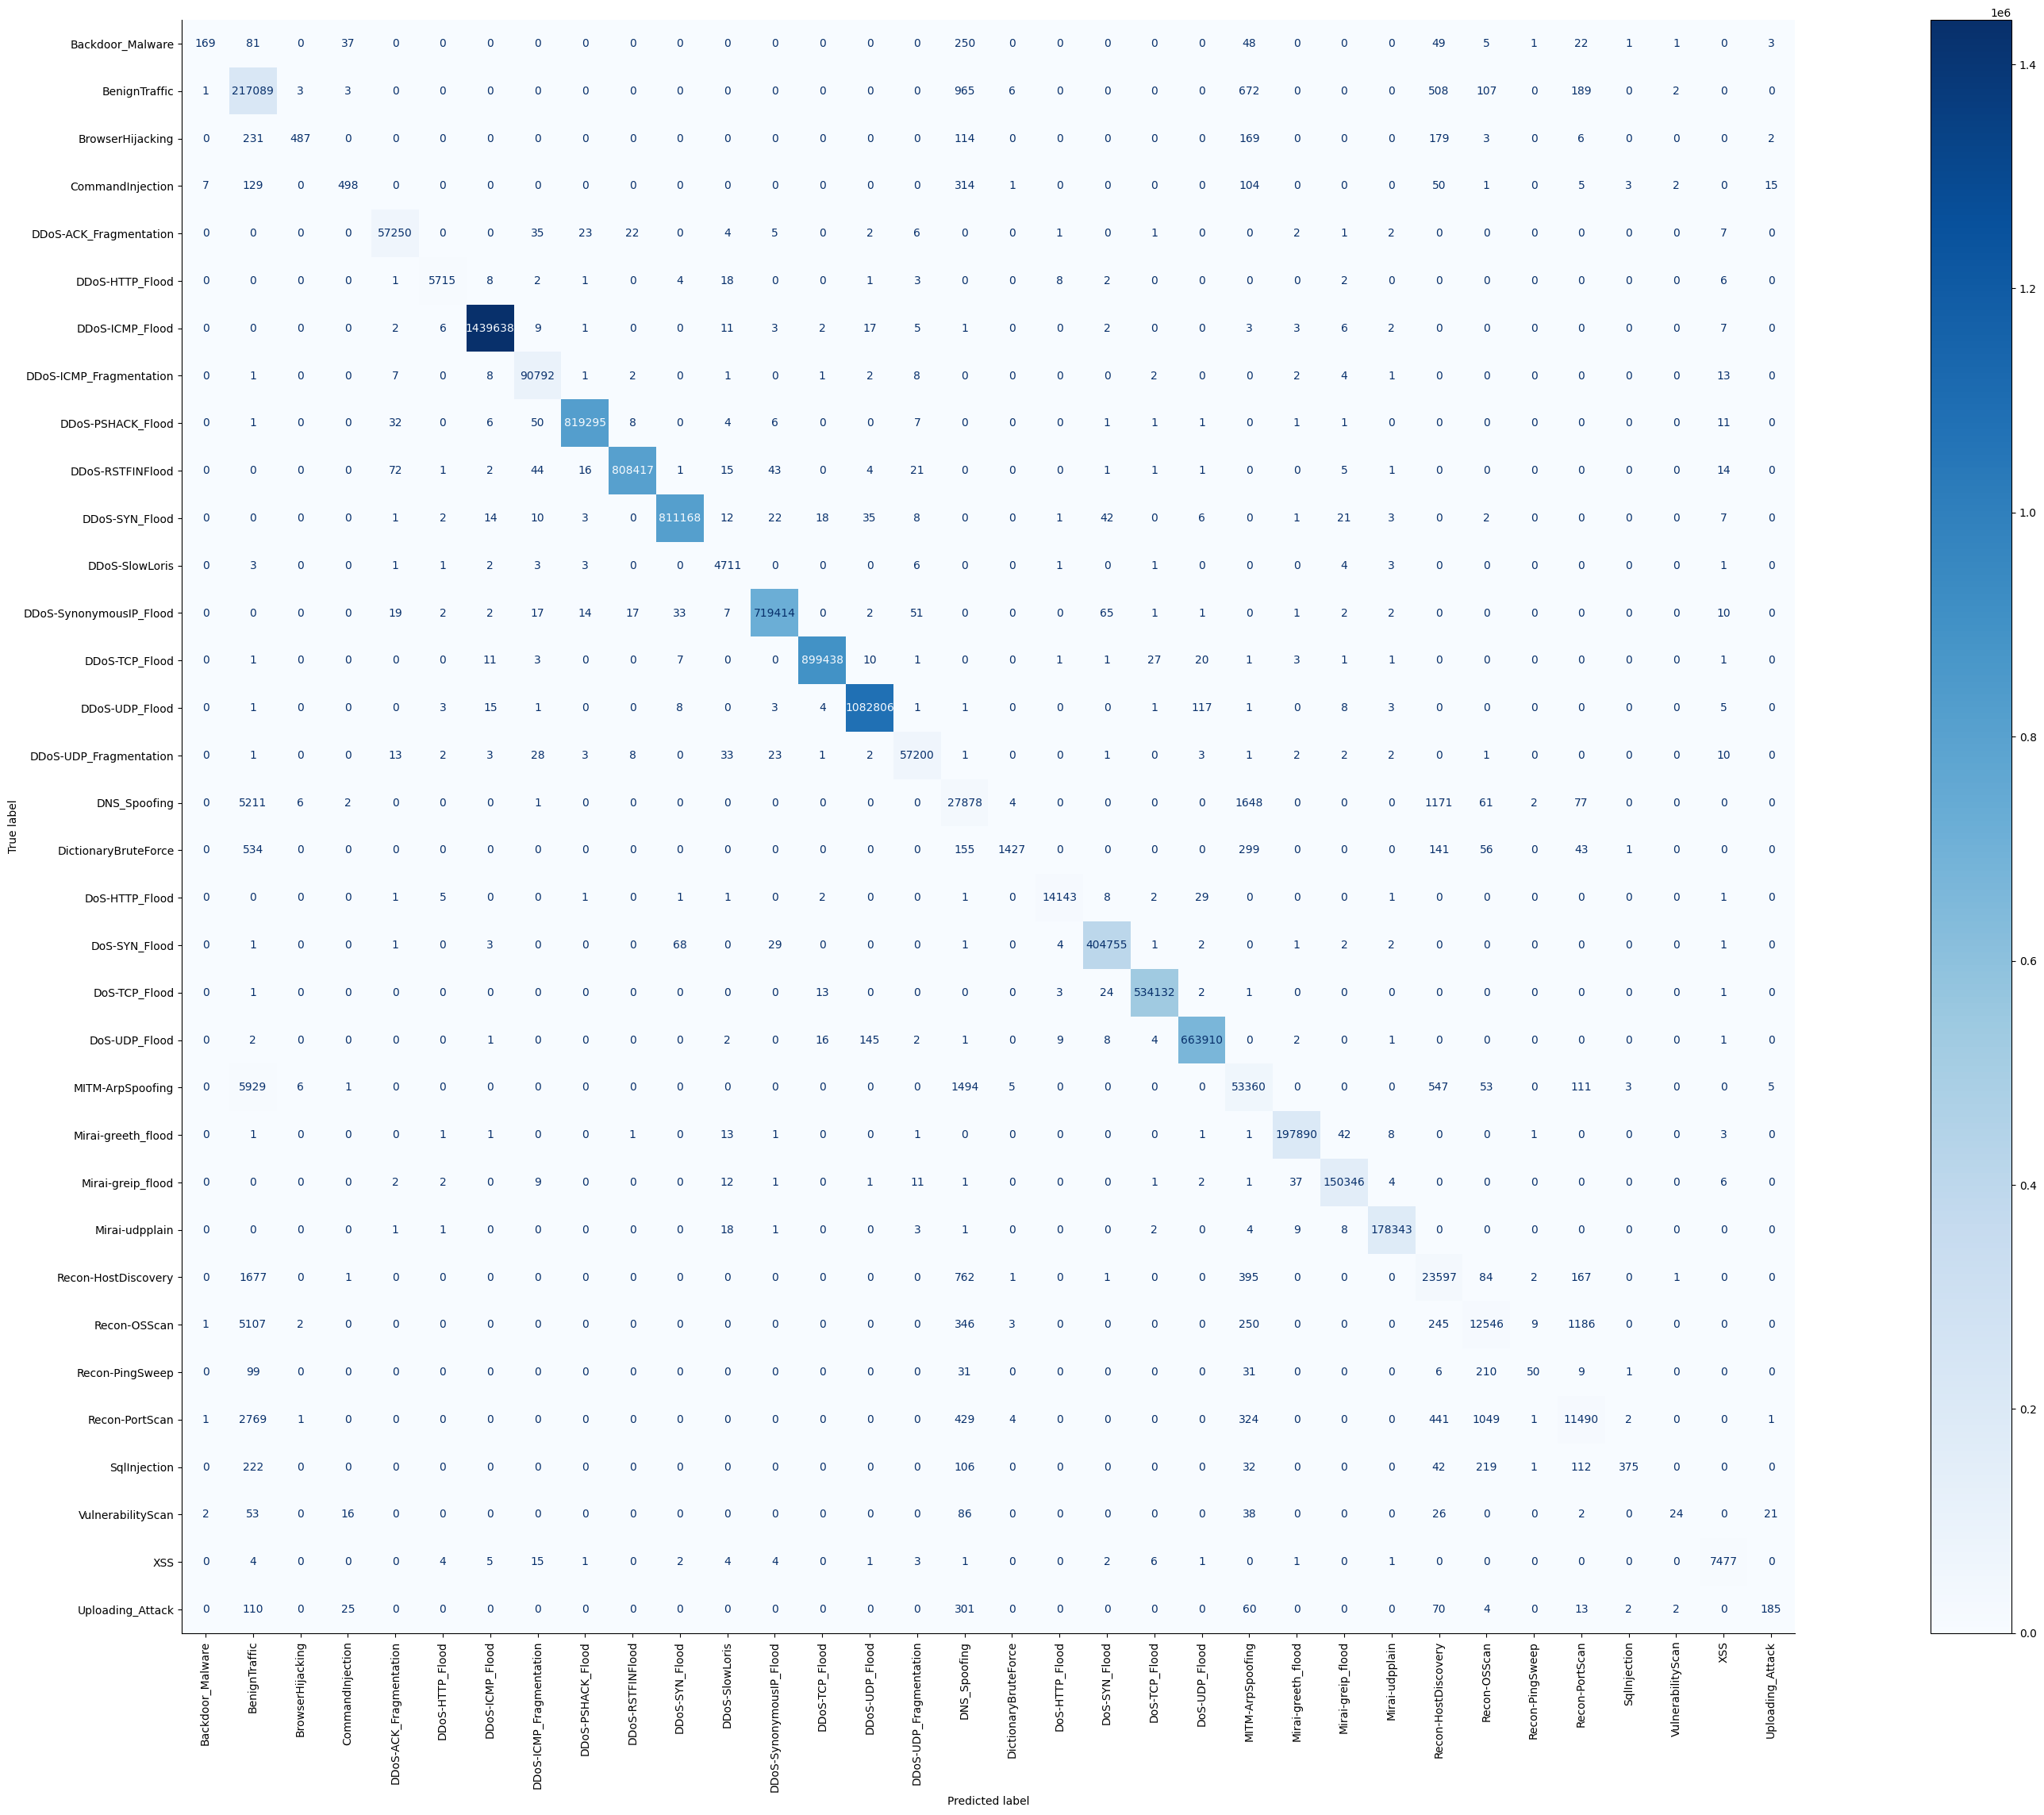

In [10]:
%%time
baseline_model = model_utils.model_load('baseline_random_forest')

print(f"# Nodes: {sum(tree.tree_.node_count for tree in baseline_model.estimators_)}")

X_train, X_test, y_train, y_test = baseline_df_split
model_utils.evaluate_model(baseline_model, X_test, y_test)

# Multi-Stage Model

In [25]:
simplified_first_layer_labels = {'DDoS', 'DoS', 'Mirai'}
simplified_second_layer_labels = {'Spoofing', 'Recon', 'Web', 'BruteForce'}

first_layer_labels = {
    attack_type
    for layer_attack in simplified_first_layer_labels
    for attack_type in attack_category[layer_attack]
}

second_layer_labels = {
    attack_type
    for layer_attack in simplified_second_layer_labels
    for attack_type in attack_category[layer_attack]
}

## 7+1 Attacks

In [18]:
simplified_multi_stage_df_split = model_utils.get_train_test_split(
    df_refined,
    target='general_label',
    train_frac=0.80
)

Training dataset size: 37.3M (80.0%).
Test dataset size: 9.3M (20.0%).


In [19]:
%%time

simplified_multi_stage_model = MultiStageClassifier(
    stages=[
        ModelStage(
            model=RandomForestClassifier(
                class_weight='balanced',
                criterion='entropy',
                max_features=10,
                n_jobs=n_jobs,
                random_state=seed
            ),
            labels=simplified_first_layer_labels
        ),
        ModelStage(
            model=RandomForestClassifier(
                class_weight='balanced',
                criterion='entropy',
                max_features=10,
                n_jobs=n_jobs,
                random_state=seed
            ),
            labels=simplified_second_layer_labels
        ),
    ]
)

X_train, X_test, y_train, y_test = simplified_multi_stage_df_split

model_utils.train_model(
    simplified_multi_stage_model,
    X_train,
    y_train,
    save_name='simplified_multi_stage_model'
)

Execution time (Model fit): 0:22:58.373682
CPU times: user 8h 10min 10s, sys: 4min 25s, total: 8h 14min 35s
Wall time: 23min 1s


MultiStageClassifier(stages=[ModelStage(model=RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features=10, n_jobs=30, random_state=6958), labels={'Mirai', 'DoS', 'DDoS'}),
                             ModelStage(model=RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features=10, n_jobs=30, random_state=6958), labels={'Recon', 'Web', 'BruteForce', 'Spoofing'})])

# Nodes (1st stage): 868432
# Nodes (2nd stage): 17578014
Execution time (Predict): 0:00:19.978939
              precision    recall  f1-score   support

      Benign     0.9273    0.9821    0.9539    219545
  BruteForce     0.9837    0.6148    0.7567      2656
        DDoS     1.0000    1.0000    1.0000   6797400
         DoS     0.9999    0.9999    0.9999   1617348
       Mirai     1.0000    1.0000    1.0000    526792
       Recon     0.9168    0.8612    0.8881     70864
    Spoofing     0.9343    0.8806    0.9066     97575
         Web     0.9758    0.5800    0.7276      5136

    accuracy                         0.9969   9337316
   macro avg     0.9672    0.8648    0.9041   9337316
weighted avg     0.9969    0.9969    0.9969   9337316

CPU times: user 4min 22s, sys: 20.1 s, total: 4min 42s
Wall time: 1min 24s


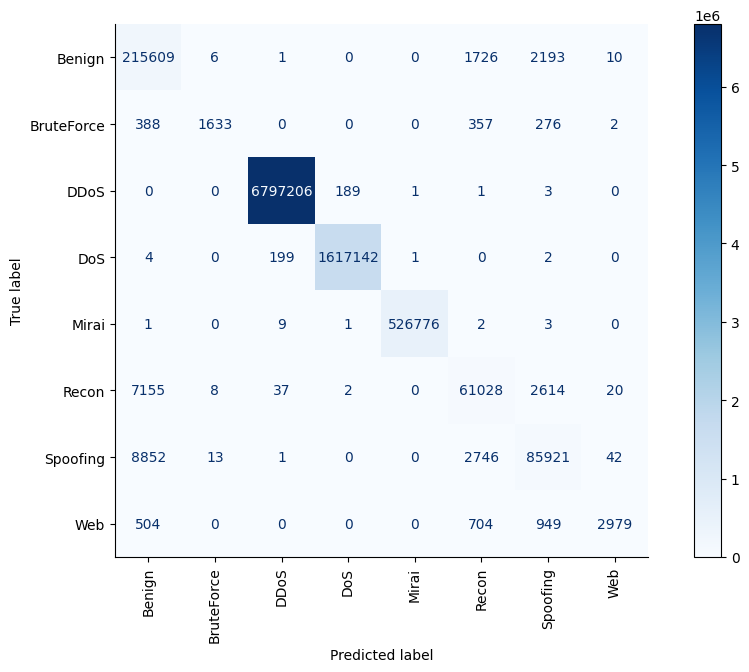

In [20]:
%%time
multi_stage_baseline_model = model_utils.model_load('simplified_multi_stage_model')

print(f"# Nodes (1st stage): {sum(tree.tree_.node_count for tree in multi_stage_baseline_model.stages[0].model.estimators_)}")
print(f"# Nodes (2nd stage): {sum(tree.tree_.node_count for tree in multi_stage_baseline_model.stages[1].model.estimators_)}")

X_train, X_test, y_train, y_test = multi_stage_df_split
model_utils.evaluate_model(multi_stage_baseline_model, X_test, y_test)

## 33+1 attacks

In [38]:
multi_stage_df_split = model_utils.get_train_test_split(
    df_refined,
    target='label',
    train_frac=0.80
)

Training dataset size: 37.3M (80.0%).
Test dataset size: 9.3M (20.0%).


In [39]:
%%time

multi_stage_model = MultiStageClassifier(
    default_label='BenignTraffic',
    stages=[
        ModelStage(
            model=RandomForestClassifier(
                class_weight='balanced',
                criterion='entropy',
                max_features=10,
                n_jobs=n_jobs,
                random_state=seed
            ),
            labels=first_layer_labels
        ),
        ModelStage(
            model=RandomForestClassifier(
                class_weight='balanced',
                criterion='entropy',
                max_features=10,
                n_jobs=n_jobs,
                random_state=seed
            ),
            labels=second_layer_labels
        ),
    ]
)

X_train, X_test, y_train, y_test = multi_stage_df_split

model_utils.train_model(
    multi_stage_model,
    X_train,
    y_train,
    save_name='multi_stage_model'
)

Execution time (Model fit): 0:26:04.246003
CPU times: user 9h 24min 34s, sys: 4min 26s, total: 9h 29min
Wall time: 26min 24s


MultiStageClassifier(default_label='BenignTraffic',
                     stages=[ModelStage(model=RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features=10, n_jobs=30, random_state=6958), labels={'DDoS-SYN_Flood', 'Mirai-udpplain', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'DDoS-RSTFINFlood', 'DDoS-ICMP_Fragmentation', 'DDoS-PSHACK_Flood', 'Mirai-greeth_flood', 'M...
                             ModelStage(model=RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features=10, n_jobs=30, random_state=6958), labels={'DictionaryBruteForce', 'XSS', 'DNS_Spoofing', 'Backdoor_Malware', 'BrowserHijacking', 'Recon-PortScan', 'Uploading_Attack', 'SqlInjection', 'VulnerabilityScan', 'Recon-OSScan', 'MITM-ArpSpoofing', 'CommandInjection', 'Recon-PingSweep', 'Recon-HostDiscovery'})])

# Nodes (1st stage): 2625990
# Nodes (2nd stage): 23777078
Execution time (Predict): 0:01:07.867927
                         precision    recall  f1-score   support

       Backdoor_Malware     0.9548    0.5382    0.6884       667
          BenignTraffic     0.9044    0.9906    0.9455    219545
       BrowserHijacking     0.9788    0.6205    0.7595      1191
       CommandInjection     0.9650    0.6342    0.7654      1129
 DDoS-ACK_Fragmentation     0.9999    0.9999    0.9999     57361
        DDoS-HTTP_Flood     0.9990    0.9983    0.9986      5771
        DDoS-ICMP_Flood     1.0000    1.0000    1.0000   1439718
DDoS-ICMP_Fragmentation     0.9999    0.9998    0.9999     90845
      DDoS-PSHACK_Flood     1.0000    1.0000    1.0000    819425
       DDoS-RSTFINFlood     1.0000    1.0000    1.0000    808659
         DDoS-SYN_Flood     0.9999    0.9999    0.9999    811376
         DDoS-SlowLoris     0.9964    0.9987    0.9976      4740
DDoS-SynonymousIP_Flood     1.0000    0.9999    0.9999

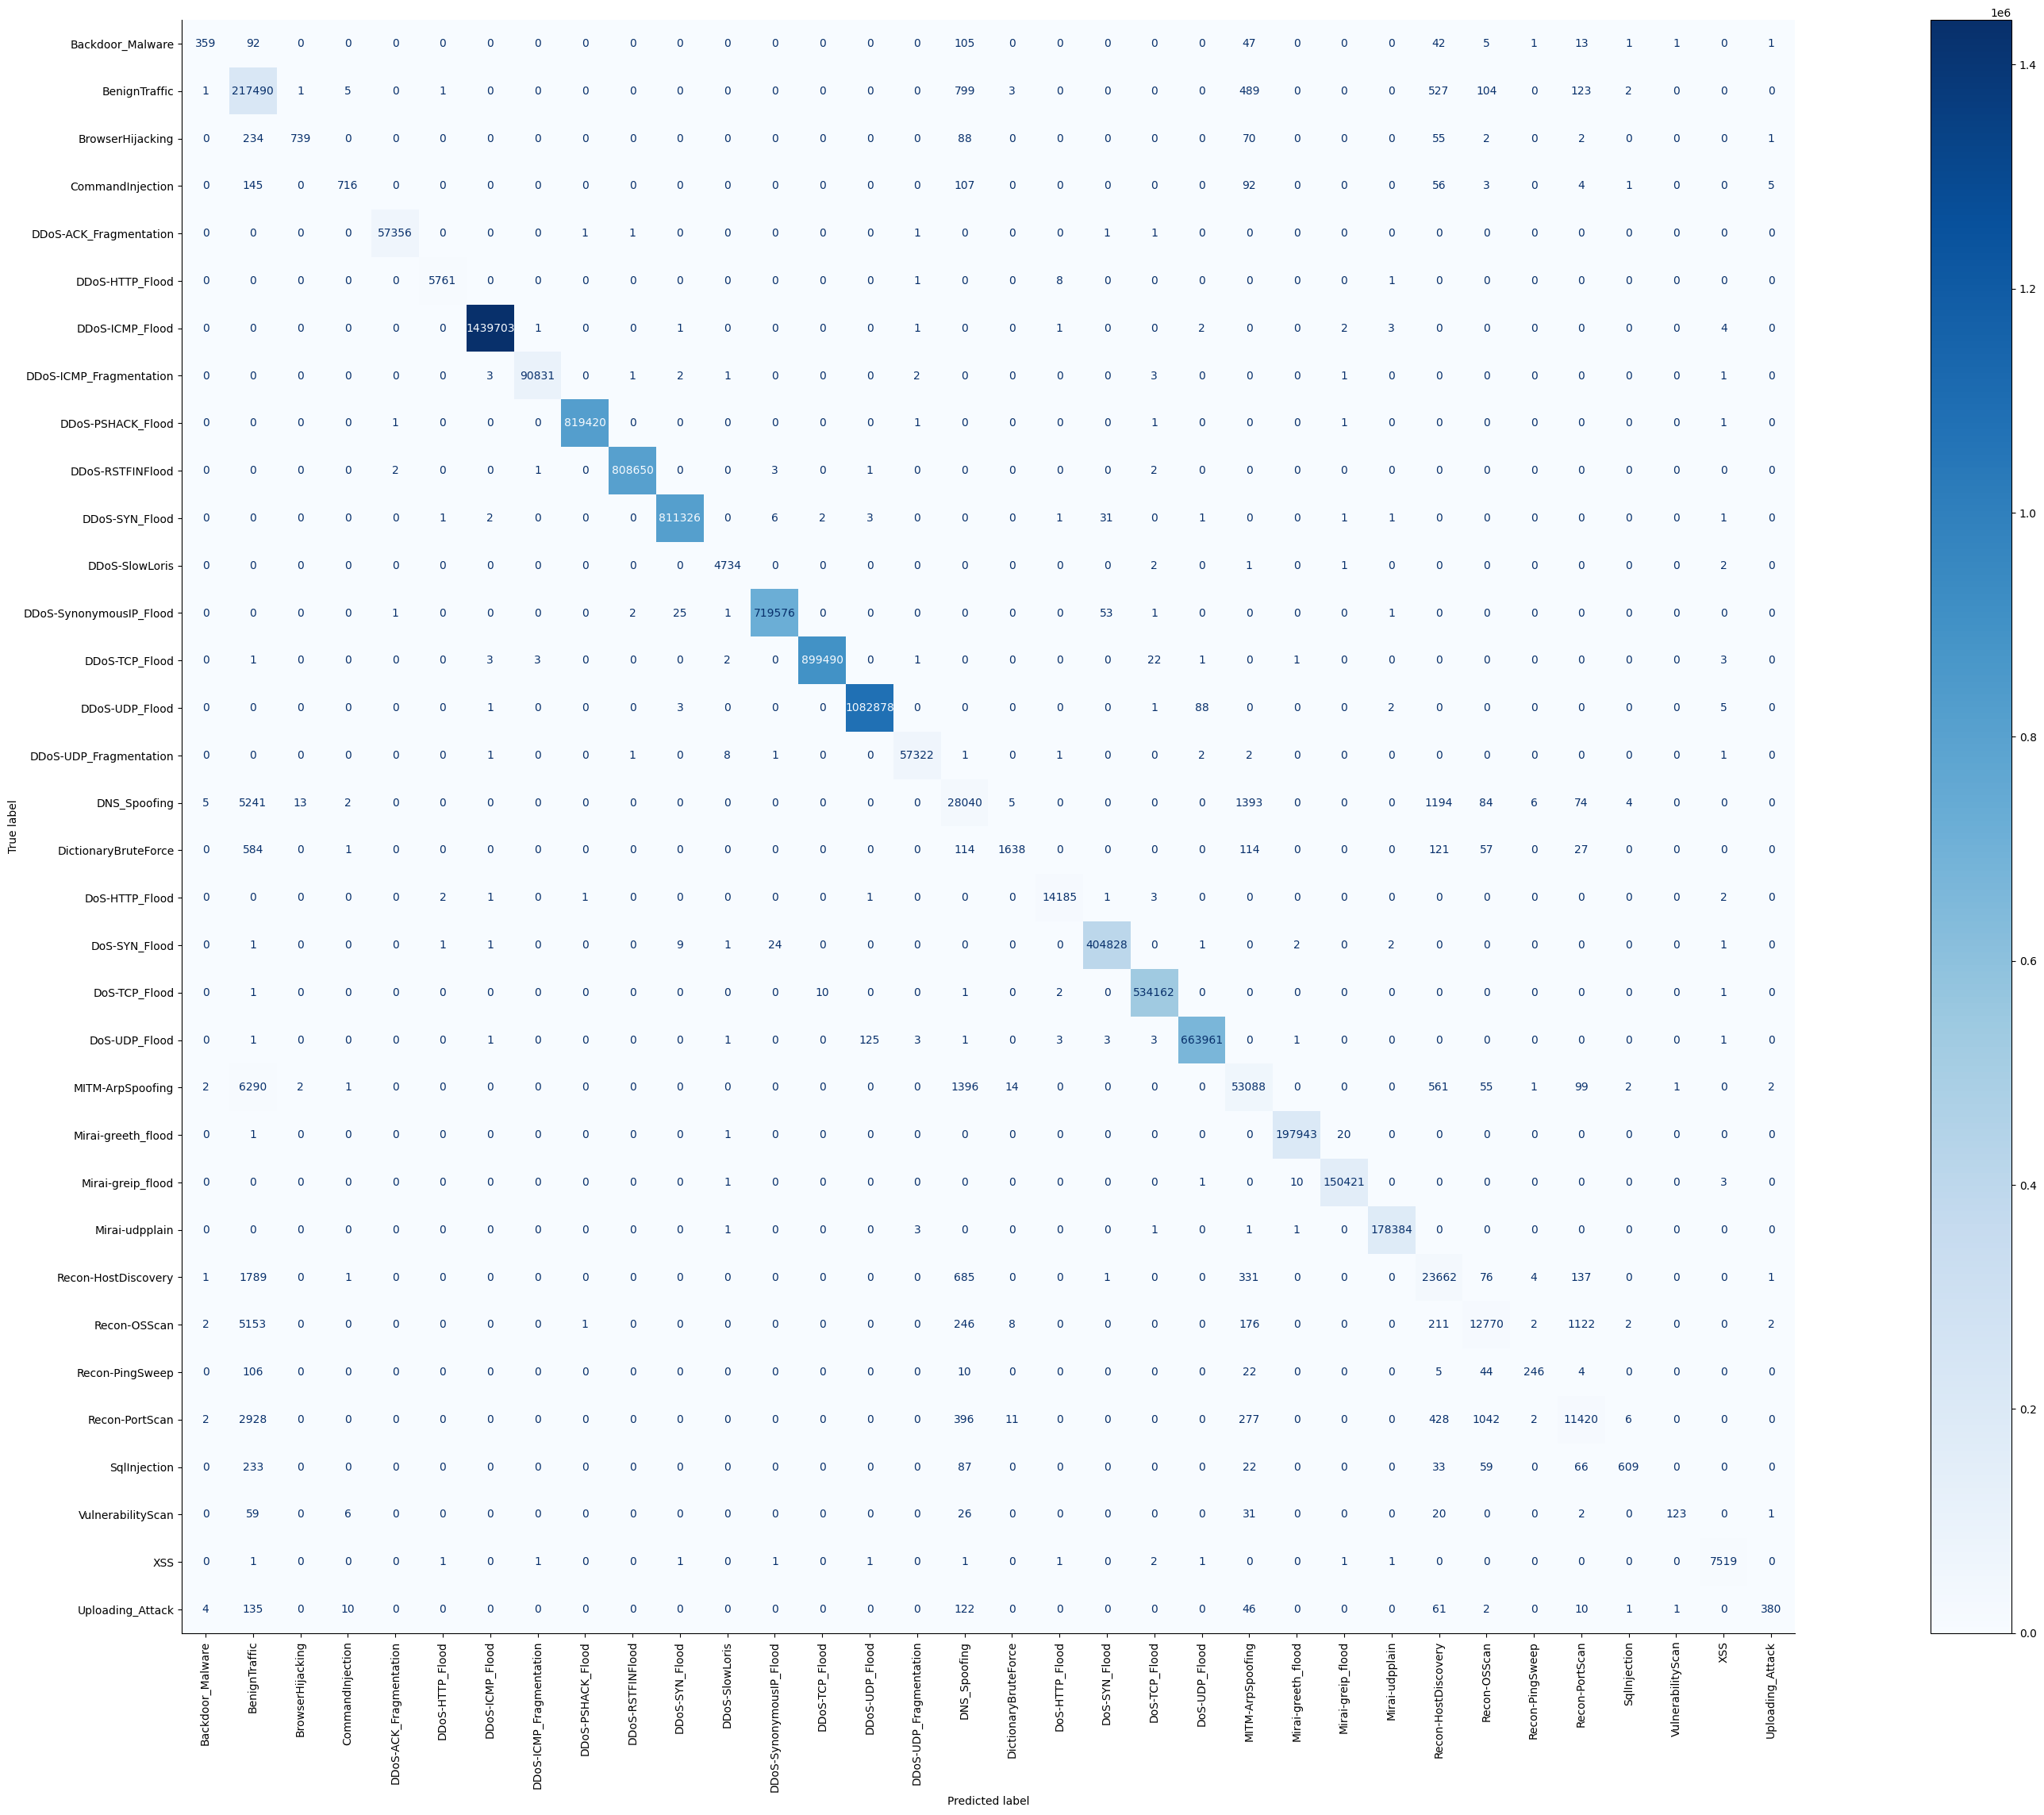

In [41]:
%%time
multi_stage_model = model_utils.model_load('multi_stage_model')

print(f"# Nodes (1st stage): {sum(tree.tree_.node_count for tree in multi_stage_model.stages[0].model.estimators_)}")
print(f"# Nodes (2nd stage): {sum(tree.tree_.node_count for tree in multi_stage_model.stages[1].model.estimators_)}")

X_train, X_test, y_train, y_test = multi_stage_df_split
model_utils.evaluate_model(multi_stage_model, X_test, y_test)